# Elastic search et word embedding

**Définition** : word embedding sur un ES en local => documents enrichi par le modèle sur ES

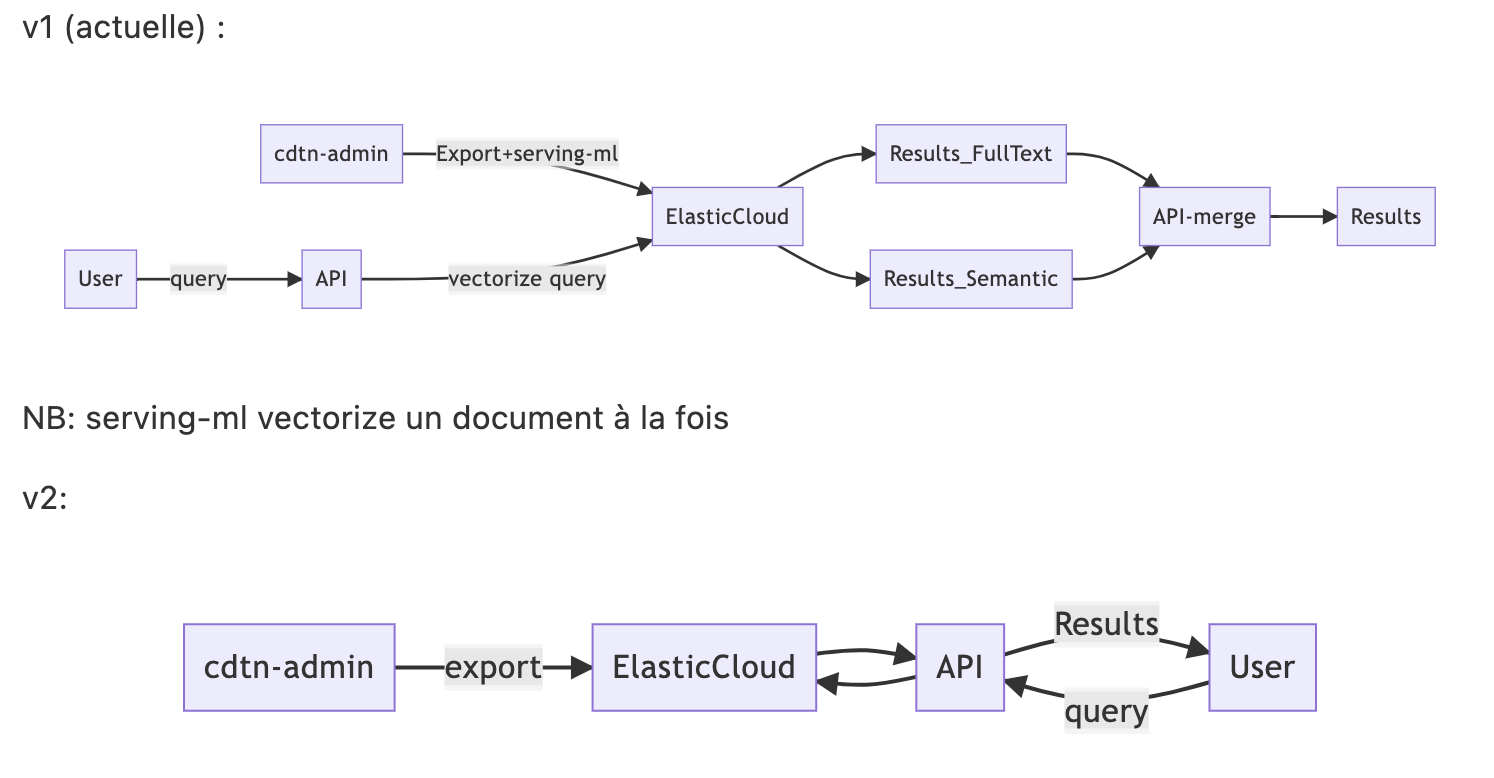

## Les imports

In [1]:
import pandas as pd
import numpy as np
import eland as ed
import time
import json
import math
import os
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from typing import List, Dict
from ast import literal_eval

from elasticsearch import helpers
from elasticsearch import Elasticsearch

from src.elasticsearch_connector import ElasticsearchConnector
from src.postgresql_connector import PostgreSQLConnector

tqdm.pandas()
load_dotenv()

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 150)

# Analyse des données présentes actuellement dans Elastic 

Regardons les données présentes dans l'index cdtn-\*documents

**NB: un downgrade d'ElasticSearch en version 7.17 a été exécuter pour les quelques lignes suivantes. Après ces lignes remettez ES en version 8 et chargez juste les données avec le pd.read_csv.**

In [2]:
QUERY = {
  "query": {
    "match_all": {}
  }
}

In [3]:
es_connector = ElasticsearchConnector('admin')

connection with ElasticSearch is KO


In [4]:
documents_es = es_connector.execute_query(QUERY, 'cdtn-preprod-v2_documents-1660747297807')

  0%|          | 0/19161 [00:00<?, ?it/s]

In [6]:
documents_es.to_csv('data/NLP/cdtn-documents.csv', index=None)

In [4]:
documents_es = pd.read_csv('data/NLP/cdtn-documents.csv')

documents_es['title_vector'] = documents_es['title_vector'].apply(
    lambda x: literal_eval(x) if not pd.isnull(x) else []
)

/var/folders/n3/w_j4sm3n2sz1q7bqf_hh0twc0000gn/T/ipykernel_48030/3483687294.py:1: DtypeWarning: Columns (0,1,2,4,15,16,18,19,20,22,23,25,26,28,29,30,31,35,36,37,38,39,40,41,42,43,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  documents_es = pd.read_csv('data/NLP/cdtn-documents.csv')


In [5]:
#documents_es.head(3)

# EXPORT

Commençons par la première brique d'`export` des données en provenance de `cdtn-admin` vers `ElasticCloud`

## Lecture des données en provenance de `cdtn-admin`

In [6]:
def read_table(table: str, schema: str = 'public') -> pd.DataFrame:
    pg_connector = PostgreSQLConnector()
    table = pd.read_sql_query(
        sql=f'''
                SELECT *
                FROM {schema}.{table}
                ''',
        con=pg_connector.connection
    )
    return table

In [7]:
documents = read_table('documents')
#documents.head(3)

In [8]:
glossary = read_table('glossary')
#glossary.head(3)

## Pré-traitement des données avant ingestion

Parmi les traitements actuels, on peut lister : 
- Pour les CCN et les contrib, les articles sont dupliqués pour chaque questions. Le titre est alors la question.
- Si IsSearchable est à false alors on a un booléen ExcludeFromSearch à True est inséré. La recherche sémantique est alors désactivé pour ces documents
- isPublished est à false => ne pas mettre les documents ? Actuellement ils y sont, mais la recherche est peut-être désactivée, je sais pas ...
- Le titre et le texte du document sont vectorisés ensemble mais pas pour certains type `source` de document comme les article du code du travail.

### Navigation dans les données

### Data cleaning et feature engineering

Pour essayer d'être iso avec le processus actuel. Nous allons commencer par nous baser sur les données déjà présentes dans elasticsearch afin d'améliorer le processus brique par brique.

In [9]:
import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

with open('data/NLP/stop_words.json') as f:
    STOPWORDS = json.load(f)

In [10]:
class DataPreparation:
    """ A améliorer car pas convaincu de ce qui est fait actuellement"""
    
    def __init__(self):
        #self.model_name = model_name
        pass
        
    def detect_language(self, text: str):
        pass
    
    def replace_special_char_by_space(self, string: str):
        special_chars = ['\'']
        return ''.join([' ' if l in special_chars else l for l in string])
    
    def remove_stop_word_from_text_using_library(self, string: str):
        stop_words = set(stopwords.words('french'))
        word_tokens = word_tokenize(string)
        return ' '.join([word for word in word_tokens if not word.lower() in stop_words])
    
    def remove_stop_word_from_text_using_personal_file(self, string: str):
        #word_tokens = word_tokenize(string) # mieux vaut utiliser ça que la ligne suivante
        word_tokens = string.split(' ')
        return ' '.join([word for word in word_tokens if not word.lower() in STOPWORDS]) # lower a supprimer si present dans preprocess_text
    
    def preprocess_text(self, text: str):
        if not pd.isnull(text) and text != '':
            #text = text.lower()
            text = unidecode.unidecode(text)
            #text = self.replace_special_char_by_space(text)
            text = self.remove_stop_word_from_text_using_personal_file(text)
            return text
        return ''
    
    def preprocess_df(self, df: pd.DataFrame, columns: List):
        df_copy = df.copy()
        for column in columns:
            df_copy[column] = df_copy[column].astype(str)
            df_copy[column + '_cleaned'] = df_copy[column].apply(self.preprocess_text)
        return df_copy
    

In [11]:
data_cleaning = DataPreparation()

In [12]:
documents_es_cleaned = data_cleaning.preprocess_df(documents_es, ['title', 'text'])

### Machine Learning 

In [13]:
import requests
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(list_a, list_b):
    if len(list_a) == len(list_b) and len(list_a)>0:
        return dot(list_a, list_b) / (norm(list_a) * norm(list_b))
    return 0

In [14]:
from abc import ABC, abstractmethod

class Vectorization(ABC):
    def __init__(
        self, 
        column_vector = 'title_text_vector'
    ):
        self.column_vector = column_vector
        self.data_cleaning = DataPreparation()
        
    def clean_documents(self, df: pd.DataFrame, columns = ['title', 'text']) -> pd.DataFrame:
        return self.data_cleaning.preprocess_df(df, columns)
    
    @abstractmethod
    def apply_model_on_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        return df.copy()
    
    @abstractmethod
    def vectorize_query(self, query: str) -> List:
        return []
    
    def get_top_N_cosin_similarity_given_a_query(self, query, df: pd.DataFrame, number_of_results = 5):
        cleaned_query = self.data_cleaning.preprocess_text(query)
        query_vectorized = self.vectorize_query(cleaned_query)
        
        df_copy = df.copy()
        df_copy['cosine_similarity'] = df_copy[self.column_vector].apply(
            lambda x: cosine_similarity(query_vectorized, x)
        )
        return df_copy.sort_values(by=['cosine_similarity'], ascending=False).head(number_of_results)
    
    def get_top_N_similarity_given_a_query_and_a_similarity_metric(
        self, query, df: pd.DataFrame, number_of_results = 5, similarity = cosine_similarity
    ):
        cleaned_query = self.data_cleaning.preprocess_text(query)
        query_vectorized = self.vectorize_query(cleaned_query)
        
        df_copy = df.copy()
        df_copy['similarity'] = df_copy[self.column_vector].apply(
            lambda x: similarity(query_vectorized, x)
        )
        return df_copy.sort_values(by=['similarity'], ascending=False).head(number_of_results)

#### API
Avant de vectorizer par un nouveau modèle, commencons par vérifier qu'on est capable d'avoir les mêmes résultats que les vectors déjà présents dans la dataframe d'elasticsearch

In [15]:
class APIVectorization(Vectorization):
    def __init__(
        self, 
        column_vector = 'title_text_vector'
    ):
        super().__init__(column_vector)
        self.api_url = 'https://serving-ml.fabrique.social.gouv.fr/v1/models/sentqam:predict'

    def callTFServe(self, body: Dict):
        r = requests.post(
            self.api_url, 
            json = body
        )
        if r.status_code == 200 and 'outputs' in r.json():
            return r.json()['outputs'][0]
        
    def vectorize_document(self, title: str, text: str = '', source: str = ''):
        body = {
            'inputs': { 
                'context': text, 
                'input': title
            },
            'signature_name': "response_encoder"
        }
        return self.callTFServe(body) if (len(title) > 0 and source not in [
            'code_du_travail', 'glossary', 'highlights', 'page_fiche_ministere_travail', 'prequalified', 'versions'
        ]) else []
        
    def vectorize_query(self, query: str):
        body = {
            'inputs': [self.data_cleaning.preprocess_text(query)],
            'signature_name': "question_encoder"
        }
        return self.callTFServe(body)

    def apply_model_on_dataframe(self, df: pd.DataFrame):
        df_copy = df.copy()
        title_vector_2 = []
        increase_by = 200
        start_time = time.time()
        
        try: 
            for i in range(0, documents_es_cleaned.shape[0], increase_by):
                if (time.time() - start_time) % 350 > 300:
                    print("Sleep 45 seconds for the API")
                    time.sleep(45)
                    
                borne_sup_i = min(i + increase_by, documents_es_cleaned.shape[0])

                title_vectors = documents_es_cleaned.iloc[i: borne_sup_i].apply(
                    lambda x: self.vectorize_document(x['title_cleaned'], x['text_cleaned'], x['source']), 
                    axis=1
                )
                print(len(title_vectors))
                title_vector_2.extend(title_vectors)
                print(f"--- {round(time.time() - start_time, 3)} seconds ---" )
        except Exception as e:
            print(e)
            print("Continuing with filling vectors with empty vectors")
        if len(title_vector_2) < documents_es_cleaned.shape[0]:
            title_vector_2.extend([ [] for _ in range(documents_es_cleaned.shape[0] - len(title_vector_2)) ])
        
        df_copy[self.column_vector] = title_vector_2
        return df_copy

In [16]:
api_vectorisation = APIVectorization()

Vectorizons une requête simple

In [17]:
api_vectorisation.vectorize_query('Congés payés')

[0.0185748953,
 -0.0486564152,
 -0.0189250018,
 -0.100321576,
 -0.0732542053,
 0.063032724,
 -0.0174473114,
 -0.000604692032,
 0.0323234499,
 -0.0217341166,
 -0.0520094857,
 -0.00697166426,
 -0.0243239142,
 0.0292466413,
 0.0309743676,
 -0.0956814364,
 0.0128794806,
 -0.0467998162,
 -0.00279853237,
 -0.0157883354,
 0.0207049157,
 -0.0663889721,
 -0.0116396062,
 0.0161452983,
 0.00364749553,
 0.011177035,
 -0.0284342431,
 0.0232386217,
 -0.0139733842,
 -0.0354977138,
 0.0777783319,
 -0.0807017386,
 0.0692691654,
 0.036085289,
 0.0110702887,
 -0.0143057341,
 -0.0460681841,
 0.0181393046,
 -0.0568549186,
 0.0884014666,
 0.00369575876,
 0.037934944,
 0.028794514,
 0.0238449965,
 0.0694872439,
 0.0388952866,
 -0.00900342222,
 -0.0752188563,
 0.00696152169,
 0.00436395,
 -0.0869462639,
 -0.0359110422,
 -0.0158964824,
 -0.0457749814,
 -0.0963013917,
 0.0974428877,
 0.0883618891,
 -0.00373499049,
 0.0285006873,
 -0.0176550914,
 0.0193724055,
 -0.00031608119,
 0.0334241129,
 -0.000677085714,
 0

Encodons un ensemble de requête sur une thématique proche (ou plus lointaine) et regardons leur cosine similaritée

In [18]:
query_assist_maternel = api_vectorisation.vectorize_query(
    'Recruter un assistant maternel : quelles sont les obligations du salarié ?')

In [19]:
query_assist_maternel_simple = api_vectorisation.vectorize_query('Recruter un assistant maternel')
cosine_similarity(query_assist_maternel, query_assist_maternel_simple)

0.4148200832469341

In [20]:
query_nounou = api_vectorisation.vectorize_query('Recruter une nounou')
cosine_similarity(query_assist_maternel, query_nounou)

0.3698338980797483

In [21]:
query_ouvrier = api_vectorisation.vectorize_query('Recruter un ouvrier')
cosine_similarity(query_assist_maternel, query_ouvrier)

0.08115204314212497

On observe bien une colinéarité plus forte entre les requêtes pour `Recruter un assistant maternel` et `Recruter une nounou`, alors que `Recruter un ouvrier` est moins similaire avec une similarité cosinus de 0.08

Calculons maintenant le vecteur de chaque documents avec un appel API par document => durée estimée 32 min = 1900 sec

In [17]:
documents_es_with_api_vector = api_vectorisation.apply_model_on_dataframe(documents_es_cleaned)

200
--- 42.905 seconds ---
200
--- 84.898 seconds ---
200
--- 126.85 seconds ---
200
--- 170.166 seconds ---
200
--- 212.118 seconds ---
200
--- 254.626 seconds ---
200
--- 297.011 seconds ---
200
--- 338.915 seconds ---
Sleep 45 seconds for the API
200
--- 426.19 seconds ---
200
--- 468.508 seconds ---
200
--- 510.838 seconds ---
200
--- 552.403 seconds ---
200
--- 595.039 seconds ---
200
--- 637.734 seconds ---
200
--- 680.263 seconds ---
Sleep 45 seconds for the API
200
--- 767.614 seconds ---
200
--- 809.837 seconds ---
200
--- 852.294 seconds ---
200
--- 895.327 seconds ---
200
--- 938.17 seconds ---
200
--- 980.769 seconds ---
200
--- 1023.109 seconds ---
Sleep 45 seconds for the API
200
--- 1110.569 seconds ---
200
--- 1153.41 seconds ---
200
--- 1196.312 seconds ---
200
--- 1238.848 seconds ---
200
--- 1281.695 seconds ---
200
--- 1325.86 seconds ---
200
--- 1371.323 seconds ---
Sleep 45 seconds for the API
200
--- 1442.949 seconds ---
200
--- 1442.954 seconds ---
200
--- 1485.

Regardons les résultats lorsque nous faisons une recherche `contrat nounou` sur l'ensemble des documents indexés

In [22]:
query = 'contrat nounou'

api_vectorisation.get_top_N_cosin_similarity_given_a_query(query, documents_es_with_api_vector, 15)[
    ['description', 'metaDescription', 'slug', 'title', 'title_cleaned', 'text', 'text_cleaned', 
     'source', 'title_vector', 'title_text_vector', 'cosine_similarity']]

,description,metaDescription,slug,title,title_cleaned,text,text_cleaned,source,title_vector,title_text_vector,cosine_similarity
1825,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,combien-de-fois-le-contrat-de-travail-peut-il-etre-renouvele,Combien de fois le contrat de travail peut-il être renouvelé ?,contrat travail peut-il renouvele ?,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,"nombre renouvellements contrat travail depend type contrat.\nLe nombre renouvellements prevu code travail s'applique, convention accord collectif ...",contributions,"[0.0201186761, 0.00344780739, -0.0258206986, 0.0600508, 0.00684480974, -0.0262490157, -0.0330542028, -0.0139978621, -0.00985313859, -0.0196210425,...","[0.0297865346, 0.000669819652, -0.0239473768, 0.0598813854, 0.0116856387, -0.023948608, -0.0310305972, -0.00761277042, -0.01334034, -0.0191561226,...",0.395838
6270,"A SAVOIR Depuis le 1er avril 2022, les demandes d’homologation de ruptures conventionnelles doivent obligatoirement être télétransmises via le sit...",NaN,la-rupture-conventionnelle-du-contrat-de-travail-a-duree-indeterminee,La rupture conventionnelle du contrat de travail à durée indéterminée,rupture conventionnelle contrat travail duree indeterminee,"A SAVOIR Depuis le 1er avril 2022, les demandes d’homologation de ruptures conventionnelles doivent obligatoirement être télétransmises via le si...","SAVOIR 1er avril 2022, demandes d'homologation ruptures conventionnelles obligatoirement teletransmises site TeleRC, cas particuliers precises ci...",fiches_ministere_travail,"[0.0259613581, -0.0163021535, 0.00235264585, 0.00479578413, -0.0599082522, -0.0547753349, -0.0451809168, -0.00726890145, -0.0449903794, -0.0489322...","[0.0319302306, -0.0153478701, 0.00998583715, -0.00246568047, -0.0622269586, -0.0567006059, -0.0487363189, -0.00154161255, -0.0481574833, -0.051441...",0.374817
373,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,29-combien-de-fois-le-contrat-de-travail-peut-il-etre-renouvele,Combien de fois le contrat de travail peut-il être renouvelé ?,contrat travail peut-il renouvele ?,0029 Combien de fois le contrat de travail peut-il être renouvelé ?,0029 contrat travail peut-il renouvele ?,contributions,"[0.0217735879, 0.0228306688, -0.0203070771, 0.0337032415, -0.0360710025, -0.0360289551, -0.051134333, -0.00250797602, -0.0260148738, -0.0412816964...","[0.0217735879, 0.0228306688, -0.0203070771, 0.0337032415, -0.0360710025, -0.0360289551, -0.051134333, -0.00250797602, -0.0260148738, -0.0412816964...",0.372854
5719,Il est possible de mettre fin au contrat de l'assistante maternelle agrée en retirant l'enfant confié. Ce retrait de l'enfant a les mêmes effets q...,Vous pouvez décider de retirer votre enfant à l'assistante maternelle agréée que vous employez et ainsi rompre son contrat de travail. Ce retrait ...,mettre-fin-au-contrat-dune-assistante-maternelle,Mettre fin au contrat d'une assistante maternelle,Mettre fin contrat d'une assistante maternelle,Il est possible de mettre fin au contrat de l'assistante maternelle agrée en retirant l'enfant confié. Ce retrait de l'enfant a les mêmes effets q...,"possible mettre fin contrat l'assistante maternelle agree retirant l'enfant confie. retrait l'enfant memes effets qu'un licenciement, obeit regles...",fiches_service_public,"[0.0307565909, -0.0561363026, -0.0105547858, 0.0746905059, -0.0217611063, 0.00719440402, -0.0422174

Le résultat vous semble-t-il cohérents ?

In [30]:
cosine_similarity(
    query_nounou,
    documents_es_with_api_vector[
        documents_es_with_api_vector['title'].str.startswith(
            'Recruter un assistant maternel : quelles sont les dispositions spécifiques en cas d’accueil dans une maison d’assistant(e)s maternel(le)s ?', na=False)
    ].title_vector[7081]
)

0.2449373822718227

Aurait-on voulu voir apparaitre l'article plus haut `Recruter un assistant maternel : Quelles sont les dispositions spécifiques en cas d’accueil dans une maison d’assistant(e)s maternel(le)s` ?

### Nouveaux modèles

Vectorizons les documents dans un nouvel index. On souhaite ajouter une colonne `title_text_vector` contenant le titre et text vectorisé.

#### distilbert model from hugging face

In [31]:
import torch

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, pipeline

In [32]:
class NLPHuggingFaceModelization(Vectorization):
    def __init__(
        self, 
        model_name = 'salti/bert-base-multilingual-cased-finetuned-squad', 
        column_vector = 'title_text_vector'
    ):
        super().__init__(column_vector)
        self.model_name = model_name
        self.model = SentenceTransformer(self.model_name)
        
    def vectorize_document(self, title: str, text: str, source: str) -> List:
        text_to_encode = title + ' ' + text
        return self.model.encode(text_to_encode) if (len(title) > 0 and source not in [
            'code_du_travail', 'glossary', 'highlights', 'page_fiche_ministere_travail', 'prequalified', 'versions'
        ]) else []

    def apply_model_on_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        df_copy = df.copy()
        df_copy[self.column_vector] = df_copy.progress_apply(
            lambda x: self.vectorize_document(x['title_cleaned'], x['text_cleaned'], x['source']), 
            axis=1
        )
        return df_copy
    
    def vectorize_query(self, query: str) -> List:
        return self.model.encode(query)

In [33]:
distilbert_multilingual_model = NLPHuggingFaceModelization()

No sentence-transformers model found with name /Users/fabien.roussel/.cache/torch/sentence_transformers/salti_bert-base-multilingual-cased-finetuned-squad. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/fabien.roussel/.cache/torch/sentence_transformers/salti_bert-base-multilingual-cased-finetuned-squad were not used when initializing BertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /Users/fabien.roussel/.cache/torch/sentence_t

In [44]:
documents_vectorized = distilbert_multilingual_model.apply_model_on_dataframe(documents_es_cleaned)

Là encore on peut regarder les résultats lorsque nous faisons une recherche `contrat nounou` sur l'ensemble des documents indexés et voir les documents les plus similaires. Est-ce que le résultat nous convient ?

In [46]:
query = 'contrat nounou'

top_5_result_query = distilbert_multilingual_model.get_top_N_cosin_similarity_given_a_query(
    query, documents_vectorized)
top_5_result_query[
    ['description', 'metaDescription', 'slug', 'title', 'title_cleaned', 'text', 'text_cleaned', 
     'source', 'title_vector', 'title_text_vector', 'cosine_similarity']]

,description,metaDescription,slug,title,title_cleaned,text,text_cleaned,source,title_vector,title_text_vector,cosine_similarity
1264,"Le code du travail prévoit le contenu obligatoire du contrat de travail uniquement pour certains contrats (CDD, contrat d’apprentissage, etc.).\nU...","Le code du travail prévoit le contenu obligatoire du contrat de travail uniquement pour certains contrats (CDD, contrat d’apprentissage, etc.). Un...",1634-quelles-informations-doivent-figurer-dans-le-contrat-de-travail-ou-la-lettre-dengagement,Quelles informations doivent figurer dans le contrat de travail ou la lettre d'engagement ?,informations figurer contrat travail lettre d'engagement ?,1634 Quelles informations doivent figurer dans le contrat de travail ou la lettre d'engagement ?,1634 informations figurer contrat travail lettre d'engagement ?,contributions,"[-0.0610840805, 0.0600250736, 0.0367086828, 0.0492509939, -0.0464376956, 0.0243776646, -0.0197075717, -0.0308621, -0.0485883914, -0.0648455843, -0...","[0.077356495, 0.3361899, 0.4306662, 0.00017901024, 0.08992603, 0.10741112, -0.48875195, -0.2348265, -0.10657663, -0.38075745, -0.21558972, 0.40577...",0.948539
3147,"Le code du travail prévoit le contenu obligatoire du contrat de travail uniquement pour certains contrats (CDD, contrat d’apprentissage, etc.).\nU...","Le code du travail prévoit le contenu obligatoire du contrat de travail uniquement pour certains contrats (CDD, contrat d’apprentissage, etc.). Un...",1518-quelles-informations-doivent-figurer-dans-le-contrat-de-travail-ou-la-lettre-dengagement,Quelles informations doivent figurer dans le contrat de travail ou la lettre d'engagement ?,informations figurer contrat travail lettre d'engagement ?,1518 Quelles informations doivent figurer dans le contrat de travail ou la lettre d'engagement ?,1518 informations figurer contrat travail lettre d'engagement ?,contributions,"[-0.0553558469, 0.0583530664, 0.0433160625, 0.0467322133, -0.0483036, 0.0244031772, -0.0246988554, -0.0293020904, -0.0518346764, -0.0660350472, -0...","[0.13118553, 0.309679, 0.44489172, 0.036856093, 0.08512009, 0.10186606, -0.48953024, -0.23495977, -0.025365828, -0.4086042, -0.25640902, 0.4244483...",0.948456
407,"Le code du travail prévoit le contenu obligatoire du contrat de travail uniquement pour certains contrats (CDD, contrat d’apprentissage, etc.).\nU...","Le code du travail prévoit le contenu obligatoire du contrat de travail uniquement pour certains contrats (CDD, contrat d’apprentissage, etc.). Un...",1516-quelles-informations-doivent-figurer-dans-le-contrat-de-travail-ou-la-lettre-dengagement,Quelles informations doivent figurer dans le contrat de travail ou la lettre d'engagement ?,informations figurer contrat travail lettre d'engagement ?,1516 Quelles informations doivent figurer dans le contrat de travail ou la lettre d'engagement ?,1516 informations figurer contrat travail lettre d'engagement ?,contributions,"[-0.0526086949, 0.0585465208, 0.0425476581, 0.0511536747, -0.0409316868, 0.025411997, -0.0186381657, -0.0388410799, -0.0497521944, -0.0631256551, ...","[0.12357544, 0.315372, 0.44752377, 0.040551282, 0.08413307, 0.093202636, -0.4936596, -0.2479333, -0.020256, -0.41190553, -0.25550795, 0.40359282, ...",0.948228
1135,"Le code du travail prévoit le contenu obligatoire du contrat de travail uniquement pour certains contrats (CDD, contrat d’apprentissage, etc.).\nU...","Le code du travail prévoit le contenu obligatoire du contrat de travail uniquement pour certains contrats (CDD, contrat d’apprentissage, etc.). Un...",1387-quelles-informations-doivent-figurer-dans-le-contrat-de-travail-ou-la-lettre-dengagement,Quelles informations doivent figurer dans le contrat de travail ou la lettre d'engagement ?,informations figurer contrat travail lettre d'engagement ?,1387 Quelles informations doivent figurer dans le contrat de travail ou la lettre d'engagement ?,1387 informations figurer contrat travail lettre d'engagement ?,contributions,"[-0.0613177046, 0

Evidemment non, les résultats sont bien en deça de ce qu'on a actuellement.

#### Test de multiple modèles de hugging face

On veut tester de multiple modèles à la chaine et selon un set de query défini, puis récupérer le meilleur modèle en fonction de leurs résulats.

On veut encoder le titre et le contenu d'un document (en mode question + contexte) et récuper le vecteur associé. Ensuite on veut encoder une requête et récupérer son vecteur afin de comparer le vecteur de chaque documents et récuper les documents les plus colinéaires.

Problème :
> Il semblerait qu'on ne puisse pas récupérer le vecteur associé à une algorithme question answer de hugging face :s 

In [114]:
models = [
    'etalab-ia/camembert-base-squadFR-fquad-piaf',
    'cmarkea/distilcamembert-base-qa',
    'fmikaelian/camembert-base-fquad',
    'illuin/camembert-base-fquad',
]

query_1 = 'recruter un assistant maternel'
query_2 = 'recruter une nounou'
query_3 = 'Congés payés'

results = { model: {} for model in models }

for model_name in models:
    try:
        model = NLPHuggingFaceModelization(model_name)
        documents_vectorized = model.apply_model_on_dataframe(documents_es_cleaned.iloc[5500:6500].copy())
        
        query_1_top_10_results = model.get_top_N_cosin_similarity_given_a_query(query_1, documents_vectorized, 10)
        query_2_top_10_results = model.get_top_N_cosin_similarity_given_a_query(query_2, documents_vectorized, 10)
        query_3_top_10_results = model.get_top_N_cosin_similarity_given_a_query(query_3, documents_vectorized, 10)
        columns = ['description', 'metaDescription', 'slug', 'title', 'title_cleaned', 'text', 'text_cleaned', 
            'source', 'title_vector', 'title_text_vector', 'cosine_similarity']
        
        results[model_name] = {
            'documents_vectorized': documents_vectorized,
            'queries': {
                'query_1_top_10_results': query_1_top_10_results[columns],
                'query_2_top_10_results': query_2_top_10_results[columns],
                'query_3_top_10_results': query_3_top_10_results[columns],
            },
        }
    except Exception as e: 
        print('____')
        print(f'{model_name} has failed...')
        print(e)
        print('Continue with next model')
        print('__________________________________________________________________________')
        continue

No sentence-transformers model found with name /Users/fabien.roussel/.cache/torch/sentence_transformers/etalab-ia_camembert-base-squadFR-fquad-piaf. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/fabien.roussel/.cache/torch/sentence_transformers/etalab-ia_camembert-base-squadFR-fquad-piaf were not used when initializing CamembertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1000 [00:00<?, ?it/s]

____
etalab-ia/camembert-base-squadFR-fquad-piaf has failed...
index out of range in self
Continue with next model
__________________________________________________________________________


No sentence-transformers model found with name /Users/fabien.roussel/.cache/torch/sentence_transformers/cmarkea_distilcamembert-base-qa. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/fabien.roussel/.cache/torch/sentence_transformers/cmarkea_distilcamembert-base-qa were not used when initializing CamembertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertModel were not initialized from the model checkpoint at /Users/fabien.roussel/.cache/torch/sentence_transformers/cmarke

  0%|          | 0/1000 [00:00<?, ?it/s]

No sentence-transformers model found with name /Users/fabien.roussel/.cache/torch/sentence_transformers/fmikaelian_camembert-base-fquad. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/fabien.roussel/.cache/torch/sentence_transformers/fmikaelian_camembert-base-fquad were not used when initializing CamembertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1000 [00:00<?, ?it/s]

____
fmikaelian/camembert-base-fquad has failed...
index out of range in self
Continue with next model
__________________________________________________________________________


No sentence-transformers model found with name /Users/fabien.roussel/.cache/torch/sentence_transformers/illuin_camembert-base-fquad. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/fabien.roussel/.cache/torch/sentence_transformers/illuin_camembert-base-fquad were not used when initializing CamembertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1000 [00:00<?, ?it/s]

____
illuin/camembert-base-fquad has failed...
index out of range in self
Continue with next model
__________________________________________________________________________


In [115]:
for model in models:
    if 'queries' in results[model]:
        fig = px.bar(results[model]['queries']['query_1_top_10_results'], x="title", y="cosine_similarity")
        fig.show()
        fig = px.bar(results[model]['queries']['query_2_top_10_results'], x="title", y="cosine_similarity")
        fig.show()
        fig = px.bar(results[model]['queries']['query_3_top_10_results'], x="title", y="cosine_similarity")
        fig.show()

#### google tensorflow : 
A. universal-sentence-encoder-multilingual

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text 

In [24]:
def np_inner_similarity(list_a, list_b):
    if list_a.shape == list_b.shape and len(list_a)>0:
        return np.inner(list_a, list_b)
    return 0

In [25]:
class NLPTensorflowModelization(Vectorization):
    def __init__(
        self, 
        model_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', 
        column_vector = 'title_text_vector'
    ):
        super().__init__(column_vector)
        self.model_url = model_url
        self.model = hub.load(self.model_url)
        
    def vectorize_document(self, title: str, text: str, source: str) -> List:
        text_to_encode = title + ' ' + text
        return self.model(text_to_encode) if (len(title) > 0 and source not in [#.numpy()[0]
            'code_du_travail', 'glossary', 'highlights', 'page_fiche_ministere_travail', 'prequalified', 'versions'
        ]) else np.array([])

    def apply_model_on_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        df_copy = df.copy()
        df_copy[self.column_vector] = df_copy.apply(
            lambda x: self.vectorize_document(x['title_cleaned'], x['text_cleaned'], x['source']), 
            axis=1
        )
        return df_copy
    
    def vectorize_query(self, query: str) -> List:
        return self.model(query)#.numpy()[0]
    
    def get_top_N_np_inner_similarity_given_a_query(self, query, df: pd.DataFrame, number_of_results = 5):
        return self.get_top_N_similarity_given_a_query_and_a_similarity_metric(
            query, df, number_of_results, np_inner_similarity
        )

In [26]:
tf_multilingual_encoder = NLPTensorflowModelization()

In [147]:
documents_vectorized_tf = tf_multilingual_encoder.apply_model_on_dataframe(documents_es_cleaned)

In [150]:
query = 'contrat nounou'

top_5_result_query = tf_multilingual_encoder.get_top_N_np_inner_similarity_given_a_query(
    query, documents_vectorized_tf)
top_5_result_query[
    ['description', 'metaDescription', 'slug', 'title', 'title_cleaned', 'text', 'text_cleaned', 
     'source', 'title_vector', 'title_text_vector', 'similarity']]

,description,metaDescription,slug,title,title_cleaned,text,text_cleaned,source,title_vector,title_text_vector,similarity
7711,"Vous venez de trouver un travail, vous embauchez un salarié ou un apprenti ? Vous souhaitez faire une déclaration préalable à l’embauche, rédiger ...",NaN,embauche-et-contrat-de-travail,Embauche et contrat de travail,Embauche contrat travail,nan,nan,themes,"[-0.00155430613, 0.0101060728, -0.0548962131, -0.0106775928, -0.0524952859, -0.0540202484, -0.0724516809, -0.0152534489, -0.0343055837, -0.0629285...","((tf.Tensor(0.111986496, shape=(), dtype=float32), tf.Tensor(-0.0115516335, shape=(), dtype=float32), tf.Tensor(0.031248605, shape=(), dtype=float...",[[0.5685938]]
7624,NaN,NaN,contrat-de-travail,Contrat de travail,Contrat travail,nan,nan,themes,"[0.0010041988, -0.000917749421, -0.0642794743, -0.0218162145, -0.0564901456, -0.0669570416, -0.0739609674, 0.0020864089, -0.0449922197, -0.0592606...","((tf.Tensor(0.117614426, shape=(), dtype=float32), tf.Tensor(0.027390217, shape=(), dtype=float32), tf.Tensor(0.056174435, shape=(), dtype=float32...",[[0.5045234]]
7594,NaN,NaN,contrat-de-professionnalisation,Contrat de professionnalisation,Contrat professionnalisation,nan,nan,themes,"[-0.000889274233, -0.0411424264, -0.0434342511, -0.0121304831, -0.0597167, -0.0344346575, -0.0698826835, -0.00229240279, -0.0575827174, -0.0497872...","((tf.Tensor(0.14506647, shape=(), dtype=float32), tf.Tensor(0.043949485, shape=(), dtype=float32), tf.Tensor(0.021550896, shape=(), dtype=float32)...",[[0.46676058]]
7673,NaN,NaN,modification-du-contrat-de-travail,Modification du contrat de travail,Modification contrat travail,nan,nan,themes,"[-0.0154039087, 0.0516602509, -0.0533654951, -0.0140936123, -0.0540906712, -0.0682845265, -0.0700915232, -0.0297859367, -0.0163081978, -0.0588567,...","((tf.Tensor(0.10860822, shape=(), dtype=float32), tf.Tensor(0.0029857568, shape=(), dtype=float32), tf.Tensor(0.08227189, shape=(), dtype=float32)...",[[0.4589095]]
7610,NaN,NaN,conges-payes,Congés payés,Conges payes,nan,nan,themes,"[-0.0349137597, -0.0208977927, -0.0668298602, -0.0343818553, -0.0675408095, -0.067139551, -0.0762823522, 0.0110782022, -0.00753935846, -0.06229295...","((tf.Tensor(0.11088002, shape=(), dtype=float32), tf.Tensor(0.034834653, shape=(), dtype=float32), tf.Tensor(-0.032112397, shape=(), dtype=float32...",[[0.45721114]]


Les performances sont particulièrement mauvaises car l'algorithme n'est simplement pas adapté.

B. universal-sentence-encoder-multilingual-qa

C'est l'algo qui est actuellement utilisé dans l'API

In [27]:
documents_es_cleaned.source.value_counts()

code_du_travail                 11137
contributions                    4909
fiches_ministere_travail         1392
fiches_service_public             551
conventions_collectives           373
prequalified                      309
page_fiche_ministere_travail      283
themes                            120
modeles_de_courriers               39
information                        27
outils                              8
external                            8
dossiers                            2
highlights                          1
glossary                            1
versions                            1
Name: source, dtype: int64

In [28]:
class NLPTensorflowMultilingualQaModelization(Vectorization):
    def __init__(
        self, 
        model_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-qa/3', 
        column_vector = 'title_text_vector'
    ):
        super().__init__(column_vector)
        self.model_url = model_url
        self.model = hub.load(self.model_url)
        
    def vectorize_document(self, title: str, text: str, source: str) -> List:
        return self.model.signatures['response_encoder'](
            input=tf.constant(title), 
            context=tf.constant(text)
        )['outputs'].numpy()[0] if (len(title) > 0 and source not in [
            'code_du_travail', 'glossary', 'highlights', 'page_fiche_ministere_travail', 'prequalified', 'versions'
        ]) else []

    def apply_model_on_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        df_copy = df.copy()
        df_copy[self.column_vector] = df_copy.apply(
            lambda x: self.vectorize_document(x['title_cleaned'], x['text_cleaned'], x['source']), 
            axis=1
        )
        return df_copy
    
    def vectorize_query(self, query: str) -> List:
        return self.model.signatures['question_encoder'](tf.constant(query))['outputs'].numpy()[0]

In [29]:
tf_multilingual_encoder = NLPTensorflowMultilingualQaModelization()

In [203]:
documents_vectorized_tf = tf_multilingual_encoder.apply_model_on_dataframe(documents_es_cleaned)

In [210]:
query = 'contrat nounou'

top_15_result_query = tf_multilingual_encoder.get_top_N_cosin_similarity_given_a_query(
    query, documents_vectorized_tf, 15)
top_15_result_query[
    ['description', 'metaDescription', 'slug', 'title', 'title_cleaned', 'text', 'text_cleaned', 
     'source', 'title_vector', 'title_text_vector', 'cosine_similarity']]

,description,metaDescription,slug,title,title_cleaned,text,text_cleaned,source,title_vector,title_text_vector,cosine_similarity
1825,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,combien-de-fois-le-contrat-de-travail-peut-il-etre-renouvele,Combien de fois le contrat de travail peut-il être renouvelé ?,contrat travail peut-il renouvele ?,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,"nombre renouvellements contrat travail depend type contrat.\nLe nombre renouvellements prevu code travail s'applique, convention accord collectif ...",contributions,"[0.0201186761, 0.00344780739, -0.0258206986, 0.0600508, 0.00684480974, -0.0262490157, -0.0330542028, -0.0139978621, -0.00985313859, -0.0196210425,...","[0.029786514, 0.0006698114, -0.023947382, 0.0598814, 0.011685638, -0.023948628, -0.031030593, -0.007612764, -0.01334034, -0.019156156, -0.0345546,...",0.395838
6270,"A SAVOIR Depuis le 1er avril 2022, les demandes d’homologation de ruptures conventionnelles doivent obligatoirement être télétransmises via le sit...",NaN,la-rupture-conventionnelle-du-contrat-de-travail-a-duree-indeterminee,La rupture conventionnelle du contrat de travail à durée indéterminée,rupture conventionnelle contrat travail duree indeterminee,"A SAVOIR Depuis le 1er avril 2022, les demandes d’homologation de ruptures conventionnelles doivent obligatoirement être télétransmises via le si...","SAVOIR 1er avril 2022, demandes d'homologation ruptures conventionnelles obligatoirement teletransmises site TeleRC, cas particuliers precises ci...",fiches_ministere_travail,"[0.0259613581, -0.0163021535, 0.00235264585, 0.00479578413, -0.0599082522, -0.0547753349, -0.0451809168, -0.00726890145, -0.0449903794, -0.0489322...","[0.03193023, -0.015347908, 0.009985818, -0.0024656747, -0.06222695, -0.056700595, -0.04873632, -0.0015416023, -0.04815748, -0.0514414, 0.018797781...",0.374817
373,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,Le nombre de renouvellements du contrat de travail dépend du type de contrat.\nLe nombre de renouvellements prévu par le code du travail s’appliqu...,29-combien-de-fois-le-contrat-de-travail-peut-il-etre-renouvele,Combien de fois le contrat de travail peut-il être renouvelé ?,contrat travail peut-il renouvele ?,0029 Combien de fois le contrat de travail peut-il être renouvelé ?,0029 contrat travail peut-il renouvele ?,contributions,"[0.0217735879, 0.0228306688, -0.0203070771, 0.0337032415, -0.0360710025, -0.0360289551, -0.051134333, -0.00250797602, -0.0260148738, -0.0412816964...","[0.021773573, 0.022830661, -0.02030708, 0.033703253, -0.036071006, -0.03602897, -0.051134333, -0.0025079723, -0.02601487, -0.041281722, -0.0133107...",0.372854
5719,Il est possible de mettre fin au contrat de l'assistante maternelle agrée en retirant l'enfant confié. Ce retrait de l'enfant a les mêmes effets q...,Vous pouvez décider de retirer votre enfant à l'assistante maternelle agréée que vous employez et ainsi rompre son contrat de travail. Ce retrait ...,mettre-fin-au-contrat-dune-assistante-maternelle,Mettre fin au contrat d'une assistante maternelle,Mettre fin contrat d'une assistante maternelle,Il est possible de mettre fin au contrat de l'assistante maternelle agrée en retirant l'enfant confié. Ce retrait de l'enfant a les mêmes effets q...,"possible mettre fin contrat l'assistante maternelle agree retirant l'enfant confie. retrait l'enfant memes effets qu'un licenciement, obeit regles...",fiches_service_public,"[0.0307565909, -0.0561363026, -0.0105547858, 0.0746905059, -0.0217611063, 0.00719440402, -0.0422174

In [211]:
top_5_result_query[top_5_result_query['title'].str.startswith(
    'Recruter un assistant maternel : quelles sont les dispositi', na=False)]

,date,intro,references,description,sectionDisplayMode,breadcrumbs,cdtnId,excludeFromSearch,id,isPublished,metaDescription,slug,source,text,title,contents,title_vector,html,author,fileUrl,filename,filesize,icon,action,url,populars,sections,index,split,answers,longTitle,shortTitle,num,mtime,effectif,date_publi,articlesByTheme,contributions,synonymes,highlight,raw,referencedTexts,anchor,children,position,refs,variants,data,dateDebut,notaHtml,title_cleaned,text_cleaned,title_text_vector,cosine_similarity
7081,NaN,NaN,[],"Par dérogation au principe selon lequel l’enfant confié à un assistant maternel agréé est gardé au domicile de ce dernier, l’assistant maternel pe...",NaN,"[{'label': 'Embauche et contrat de travail', 'position': 0, 'slug': '/themes/embauche-et-contrat-de-travail'}, {'label': 'Embauche', 'position': 1...",NaN,False,article112731#Quelles-sont-les-dispositions-specifiques-en-cas-d-accueil-dans-une-maison-nbsp,True,NaN,recruter-un-assistant-maternel-les-obligations-a-respecter#Quelles-sont-les-dispositions-specifiques-en-cas-d-accueil-dans-une-maison-nbsp,fiches_ministere_travail,"Par dérogation au principe selon lequel l’enfant confié à un assistant maternel agréé est gardé au domicile de ce dernier, l’assistant maternel pe...",Recruter un assistant maternel : quelles sont les dispositions spécifiques en cas d’accueil dans une maison d’assistant(e)s maternel(le)s ?,NaN,"[-0.0577896908, 0.0103806872, -0.0212681126, 0.0658428073, -0.0530268401, -0.000842179696, -0.0639470294, -0.0654870942, 0.0762480497, -0.05370089...","<p>Par dérogation au principe selon lequel l’enfant confié à un assistant maternel agréé est gardé au domicile de ce dernier, l’assistant maternel...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quelles-sont-les-dispositions-specifiques-en-cas-d-accueil-dans-une-maison-nbsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Recruter assistant maternel : dispositions specifiques cas d'accueil maison d'assistant(e)s maternel(le)s ?,"derogation principe l'enfant confie assistant maternel agree garde domicile dernier, l'assistant maternel accueillir mineurs sein d'un lieu appele...","[-0.047496367, 0.004898194, -0.023778258, 0.07383586, -0.03738846, 0.020407151, -0.06416592, -0.06792189, 0.07893352, -0.06049071, -0.0060026185, ...",0.221027


Les performances sont évidemment similaire à l'API (ce qui est rassurant)

Pour passer à la partie recherche dans elasticsearch, il faut aller dans le notebook [EXPLO_7_part_2_Elasticsearch_and_word_embedding](http://localhost:8888/notebooks/EXPLO_7_part_2_Elasticsearch_and_word_embedding.ipynb)